# Machine Learning Notebook for Inspection Analysis
This notebook aims to analyze inspection data with the goal of:
**Improving inspections and identifying establishments requiring reinspection by enhancing inspection scores by 15% by the end of the year.**

## Methodology
1. **Data Cleaning and Transformation**
2. **Exploratory Data Analysis (EDA)**
3. **Unsupervised Learning (Clustering)**
4. **Supervised Learning (Classification and Regression)**
5. **Model Optimization and Explainability**
6. **Storytelling and Insights**

## Section 1: Data Loading

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
import pyodbc

In [261]:
# Connection parameters
server = r'DS'
database = 'SA_Inspections'
driver = '{ODBC Driver 17 for SQL Server}'

# Establish the connection
try:
    conn = pyodbc.connect(
        f'SERVER={server};'
        f'DATABASE={database};'
        f'DRIVER={driver};'
        f'Trusted_Connection=yes;'
    )
    print("Connection successful")
except Exception as e:
    print("Error connecting to SQL Server:", e)

Connection successful


In [262]:
# Load dataset
file_path = 'FinalDataset.csv'
dataset = pd.read_csv(file_path, delimiter=';')

# Initial overview of the dataset
print(f"Dataset Shape: {dataset.shape}")
print("Columns:", dataset.columns.tolist())
dataset.head()


Dataset Shape: (63107, 30)
Columns: ['serial_number', 'activity_date', 'facility_name', 'score', 'grade', 'service_code', 'service_description', 'employee_id', 'facility_address', 'facility_city', 'facility_id', 'facility_state', 'facility_zip', 'owner_id', 'owner_name', 'pe_description', 'program_element_pe', 'program_name', 'program_status', 'record_id', 'average_previous_score', 'score_variance', 'annual_inspections_count', 'total_violations', 'days_since_last_inspection', 'recent_violations_count', 'establishment_type', 'seating_capacity', 'cuisine_type', 'ownership_changes']


,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,average_previous_score,score_variance,annual_inspections_count,total_violations,days_since_last_inspection,recent_violations_count,establishment_type,seating_capacity,cuisine_type,ownership_changes
0,DAJ00E07B,12/29/2017 12:00:00 AM,HABITAT COFFEE SHOP,95.0,A,1.0,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,93.37,2.46,3.0,9,115,3,Market,84,Grocery,3
1,DAQOKRFZB,12/29/2017 12:00:00 AM,REILLY'S,NaN,A,1.0,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,96.72,4.21,3.0,15,196,7,Restaurant,60,Grocery,4
2,DASJI4LUR,12/29/2017 12:00:00 AM,STREET CHURROS,93.0,NaN,1.0,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,95.19,2.07,1.0,6,92,6,Market,12,Fine Dining,1
3,DA40LU5AT,12/29/2017 12:00:00 AM,TRINITI ECHO PARK,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,1814 W SUNSET BLVD,LOS ANGELES,...,99.83,3.17,1.0,15,122,5,Market,62,Fast Food,4
4,DAXV2RMYC,12/29/2017 12:00:00 AM,POLLEN,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,2100 ECHO PARK AVE,LOS ANGELES,...,95.47,3.25,3.0,9,179,1,Cafe,89,Bakery,3


In [263]:
print("Aperçu des données :")
print(dataset.head())
print("\nInformations sur les colonnes :")
print(dataset.info())
# Generate descriptive statistics.
dataset.describe()

Aperçu des données :
  serial_number           activity_date        facility_name  score grade  \
0     DAJ00E07B  12/29/2017 12:00:00 AM  HABITAT COFFEE SHOP   95.0     A   
1     DAQOKRFZB  12/29/2017 12:00:00 AM             REILLY'S    NaN     A   
2     DASJI4LUR  12/29/2017 12:00:00 AM       STREET CHURROS   93.0   NaN   
3     DA40LU5AT  12/29/2017 12:00:00 AM    TRINITI ECHO PARK   94.0     A   
4     DAXV2RMYC  12/29/2017 12:00:00 AM               POLLEN   94.0     A   

   service_code service_description employee_id           facility_address  \
0           1.0  ROUTINE INSPECTION   EE0000923     3708 N EAGLE ROCK BLVD   
1           1.0  ROUTINE INSPECTION   EE0000633        100 WORLD WAY # 120   
2           1.0  ROUTINE INSPECTION   EE0000835  6801 HOLLYWOOD BLVD # 253   
3           1.0  ROUTINE INSPECTION   EE0000923         1814 W SUNSET BLVD   
4           1.0  ROUTINE INSPECTION   EE0000923         2100 ECHO PARK AVE   

  facility_city  ... average_previous_score sco

,score,service_code,program_element_pe,average_previous_score,score_variance,annual_inspections_count,total_violations,days_since_last_inspection,recent_violations_count,seating_capacity,ownership_changes
count,58634.000000,58674.000000,58667.000000,63106.000000,63107.000000,63106.000000,63107.000000,63107.000000,63107.000000,63107.000000,63107.000000
mean,93.377119,7.660531,1629.466446,90.007609,2.996511,2.006624,12.438573,197.249640,4.218042,54.585022,1.997100
std,3.968591,51.184904,9.411132,4.991821,1.001073,0.815984,4.158726,96.687147,2.792079,25.985954,1.413891
min,64.000000,1.000000,1610.000000,70.100000,-1.210000,1.000000,5.000000,30.000000,0.000000,10.000000,0.000000
25%,91.000000,1.000000,1631.000000,86.640000,2.320000,1.000000,9.000000,114.000000,2.000000,32.000000,1.000000
50%,94.000000,1.000000,1632.000000,89.990000,2.990000,2.000000,13.000000,198.000000,4.000000,55.000000,2.000000
75%,96.000000,1.000000,1635.000000,93.380000,3.670000,3.000000,16.000000,281.000000,7.000000,77.000000,3.000000
max,100.000000,401.000000,1641.000000,112.770000,7.090000,3.000000,19.000000,364.000000,9.000000,99.000000,4.000000


## Section 2: Data Cleaning and Transformation

In [264]:
# Identifier les valeurs manquantes
missing_percent = dataset.isnull().mean() * 100
print("Pourcentage de valeurs manquantes :")
print(missing_percent[missing_percent > 0])

# Supprimer les colonnes avec plus de 50 % de valeurs manquantes
threshold = 50
columns_to_drop = missing_percent[missing_percent > threshold].index
dataset.drop(columns=columns_to_drop, inplace=True)

# Remplissage des valeurs manquantes
fill_values = {
    col: dataset[col].median() if dataset[col].dtype in ['float64', 'int64'] else dataset[col].mode()[0]
    for col in dataset.columns
}
dataset = dataset.fillna(value=fill_values)

print("Nettoyage des données terminé. Aperçu des données après nettoyage :")
print(dataset.head())

Pourcentage de valeurs manquantes :
serial_number               7.170361
activity_date               7.116485
facility_name               7.073700
score                       7.087962
grade                       7.015070
service_code                7.024577
service_description         6.908901
employee_id                 6.958024
facility_address            7.110146
facility_city               6.774209
facility_id                 6.927916
facility_state              7.081623
facility_zip                7.132331
owner_id                    6.862947
owner_name                  7.010316
pe_description              7.164023
program_element_pe          7.035670
program_name                7.038839
program_status              6.943762
record_id                   7.049931
average_previous_score      0.001585
annual_inspections_count    0.001585
dtype: float64
Nettoyage des données terminé. Aperçu des données après nettoyage :
  serial_number           activity_date        facility_name  score

In [265]:
# Vérification si des valeurs manquantes subsistent
if dataset.isnull().sum().sum() > 0:
    print("Des valeurs manquantes subsistent. Vérifiez vos colonnes :")
    print(dataset.isnull().sum()[dataset.isnull().sum() > 0])
else:
    print("Toutes les valeurs manquantes ont été imputées.")

Toutes les valeurs manquantes ont été imputées.


In [266]:
# Vérification et conversion de 'activity_date'
if 'activity_date' in dataset.columns:
    dataset['activity_date'] = pd.to_datetime(dataset['activity_date'], errors='coerce')
    dataset['year'] = dataset['activity_date'].dt.year
    dataset['month'] = dataset['activity_date'].dt.month
    print("Activity Date Conversion Successful. Example Data:")
    print(dataset[['activity_date', 'year', 'month']].head())
else:
    print("Column 'activity_date' is missing from the dataset.")

# Vérification des valeurs nulles dans les colonnes clés
print("Null values in 'score':", dataset['score'].isnull().sum())
print("Null values in 'year':", dataset['year'].isnull().sum())
print("Null values in 'month':", dataset['month'].isnull().sum())

# Suppression des lignes avec des valeurs nulles dans 'year', 'month', ou 'score'
dataset = dataset.dropna(subset=['year', 'month', 'score'])
print("Données nettoyées. Taille du dataset :", dataset.shape)

# Création de nouvelles colonnes (features)
dataset['inspection_frequency'] = 1 / (dataset['days_since_last_inspection'] + 1)
dataset['recent_violation_ratio'] = dataset['recent_violations_count'] / (dataset['total_violations'] + 1)
dataset['weighted_risk_score'] = dataset['score'] * dataset['recent_violation_ratio']

# Créer un dictionnaire avant de supprimer la colonne
facility_names = dataset[['facility_id', 'facility_name']].drop_duplicates().set_index('facility_id')['facility_name'].to_dict()
print("Dictionnaire des noms d'établissements créé avec succès :", len(facility_names), "établissements")


Activity Date Conversion Successful. Example Data:
  activity_date  year  month
0    2017-12-29  2017     12
1    2017-12-29  2017     12
2    2017-12-29  2017     12
3    2017-12-29  2017     12
4    2017-12-29  2017     12
Null values in 'score': 0
Null values in 'year': 0
Null values in 'month': 0
Données nettoyées. Taille du dataset : (63107, 32)
Dictionnaire des noms d'établissements créé avec succès : 13332 établissements


C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17040\1813954086.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['activity_date'] = pd.to_datetime(dataset['activity_date'], errors='coerce')


In [267]:
# Supprimer les colonnes inutiles
dataset.drop(columns=[
    'serial_number', 'activity_date', 'record_id', 'owner_id', 'employee_id',
    'facility_name', 'facility_address', 'facility_city', 'facility_state',
    'facility_zip', 'service_code', 'service_description',
    'program_element_pe', 'program_name', 'program_status',
    'pe_description', 'owner_name', 'cuisine_type'
], inplace=True)

print("Colonnes disponibles dans le dataset :", dataset.columns.tolist())

Colonnes disponibles dans le dataset : ['score', 'grade', 'facility_id', 'average_previous_score', 'score_variance', 'annual_inspections_count', 'total_violations', 'days_since_last_inspection', 'recent_violations_count', 'establishment_type', 'seating_capacity', 'ownership_changes', 'year', 'month', 'inspection_frequency', 'recent_violation_ratio', 'weighted_risk_score']


## Section 3: Exploratory Data Analysis (EDA)

In [268]:
dataset['year'] = dataset['year'].fillna(dataset['year'].median())
dataset['month'] = dataset['month'].fillna(dataset['month'].median())

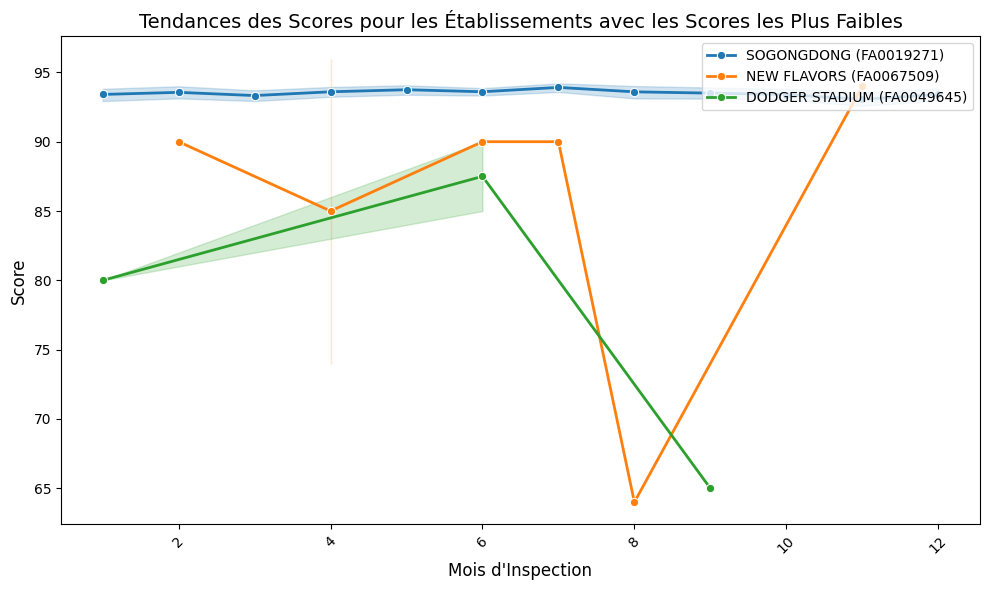

In [269]:
# Calcul du score minimum historique pour chaque établissement
dataset['min_past_score'] = dataset.groupby('facility_id')['score'].transform(lambda x: x.shift().expanding().min())

# Sélection des 3 établissements ayant les scores minimums historiques les plus bas
top_lowest_facilities = dataset.groupby('facility_id')['min_past_score'].min().nsmallest(3).index

# Filtrer les données pour ces établissements
top_lowest_data = dataset[dataset['facility_id'].isin(top_lowest_facilities)]

# Vérification des données pour chaque établissement
plt.figure(figsize=(10, 6))

for facility_id, color in zip(top_lowest_facilities, ['#1f77b4', '#ff7f0e', '#2ca02c']):
    facility_data = top_lowest_data[top_lowest_data['facility_id'] == facility_id]
    facility_name = facility_names.get(facility_id, "Unknown Facility")

    if not facility_data.empty:
        sns.lineplot(
            x=facility_data['month'], 
            y=facility_data['score'], 
            marker='o', linewidth=2, color=color,
            label=f"{facility_name} ({facility_id})"
        )

# Vérification de la légende
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right', fontsize=10)
else:
    print("Aucun tracé valide trouvé pour afficher une légende.")

# Personnalisation
plt.title("Tendances des Scores pour les Établissements avec les Scores les Plus Faibles", fontsize=14)
plt.xlabel("Mois d'Inspection", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


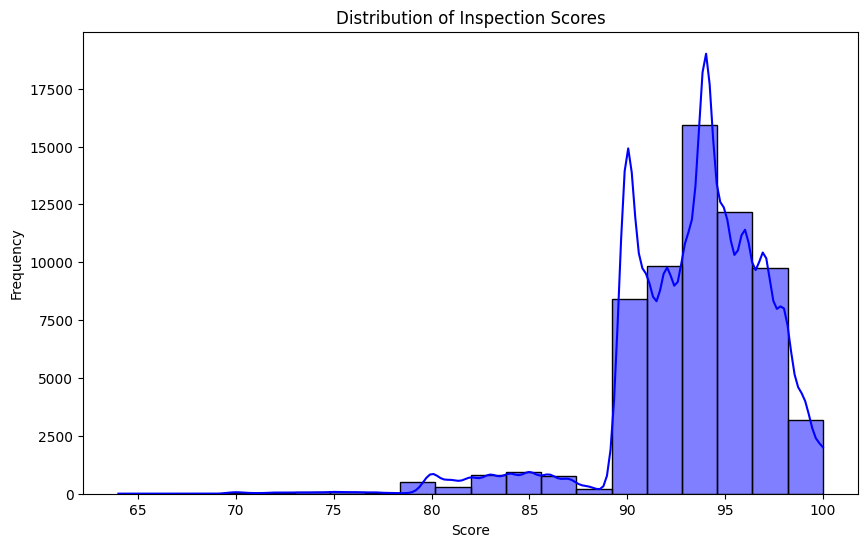

In [270]:
# Distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(dataset['score'], bins=20, kde=True, color='blue')
plt.title("Distribution of Inspection Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

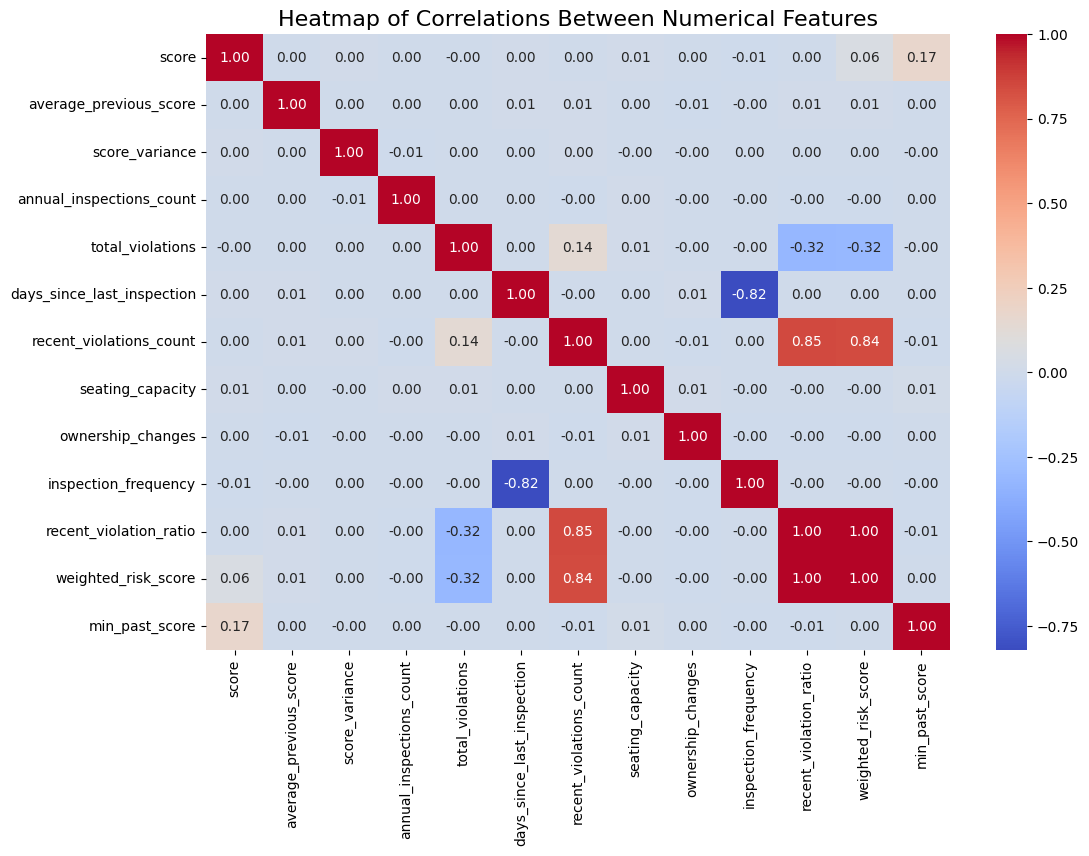

In [271]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = dataset[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlations Between Numerical Features", fontsize=16)
plt.show()


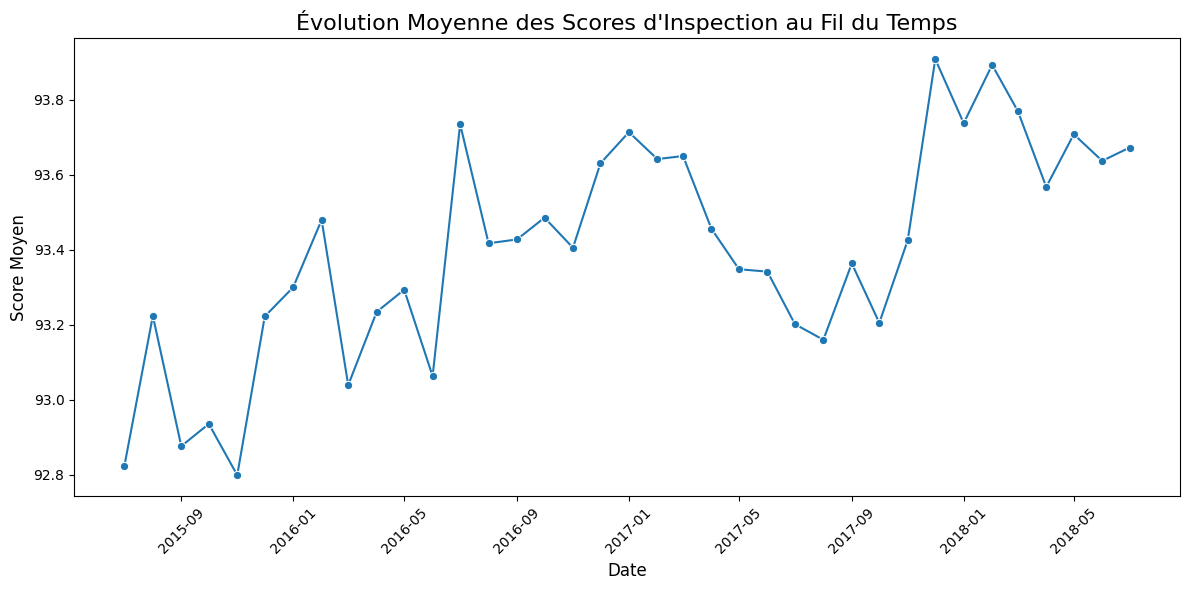

In [272]:
# Calcul des scores moyens par mois et année
average_scores_by_month = dataset.groupby(['year', 'month'])['score'].mean().reset_index()
average_scores_by_month['date'] = pd.to_datetime(average_scores_by_month[['year', 'month']].assign(day=1))

# Visualisation des scores moyens par mois/année
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='score', data=average_scores_by_month, marker='o')

# Personnalisation
plt.title("Évolution Moyenne des Scores d'Inspection au Fil du Temps", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Score Moyen", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Section 4: Clustering (Unsupervised Learning)

In [273]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Chargement et préparation des données
np.random.seed(42)
data = pd.DataFrame({
    "score": np.random.uniform(50, 100, 500),
    "recent_violation_ratio": np.random.uniform(0, 1, 500),
    "weighted_risk_score": np.random.uniform(1, 10, 500),
    "inspection_frequency": np.random.poisson(3, 500),
    "total_violations": np.random.poisson(5, 500)
})

# Normalisation des données
selected_features = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[selected_features])
print("Données normalisées.")

Données normalisées.


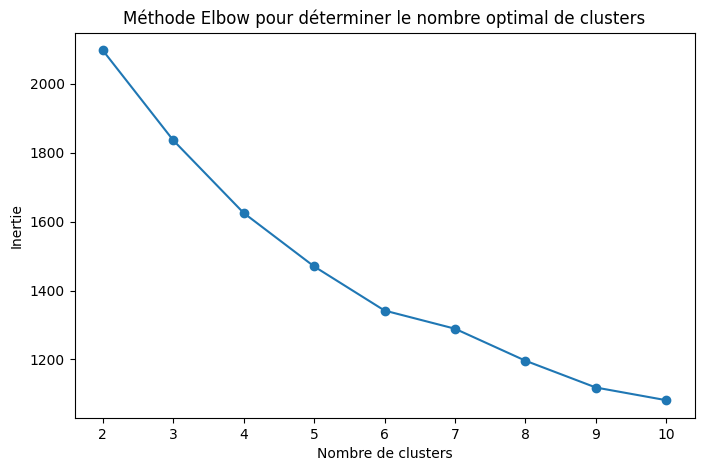

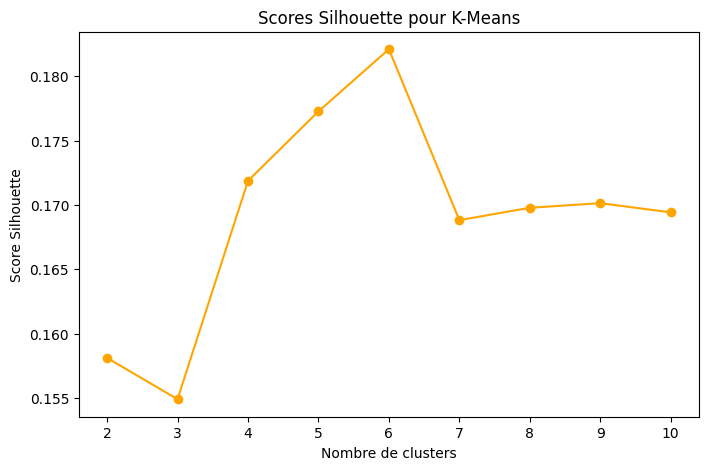

K-Means appliqué avec 6 clusters.


In [274]:
# Étape 2 : Détection du nombre optimal de clusters (K-Means)
inertias = []
silhouette_scores = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, clusters))

# Visualisation de la méthode Elbow
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertias, marker='o')
plt.title("Méthode Elbow pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

# Visualisation des scores Silhouette
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, silhouette_scores, marker='o', color='orange')
plt.title("Scores Silhouette pour K-Means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score Silhouette")
plt.show()

optimal_k = range_clusters[np.argmax(silhouette_scores)]  # Meilleur score silhouette
if optimal_k != silhouette_scores.index(max(silhouette_scores)) + 2:
    print(f"Vérifiez les résultats : Elbow suggère {optimal_k} clusters.")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data["kmeans_cluster"] = kmeans.fit_predict(data_scaled)
print(f"K-Means appliqué avec {optimal_k} clusters.")

Profiling des clusters K-Means :
                    score  recent_violation_ratio  weighted_risk_score  \
kmeans_cluster                                                           
0               66.183308                0.577151             3.671336   
1               86.234381                0.711115             4.227541   
2               62.119067                0.696312             7.841555   
3               65.038741                0.234622             3.682338   
4               78.689139                0.303016             6.277190   
5               87.328234                0.321826             7.895119   

                inspection_frequency  total_violations  
kmeans_cluster                                          
0                           3.161290          7.854839  
1                           2.303922          3.637255  
2                           2.853933          4.314607  
3                           2.388235          4.011765  
4                           5.66

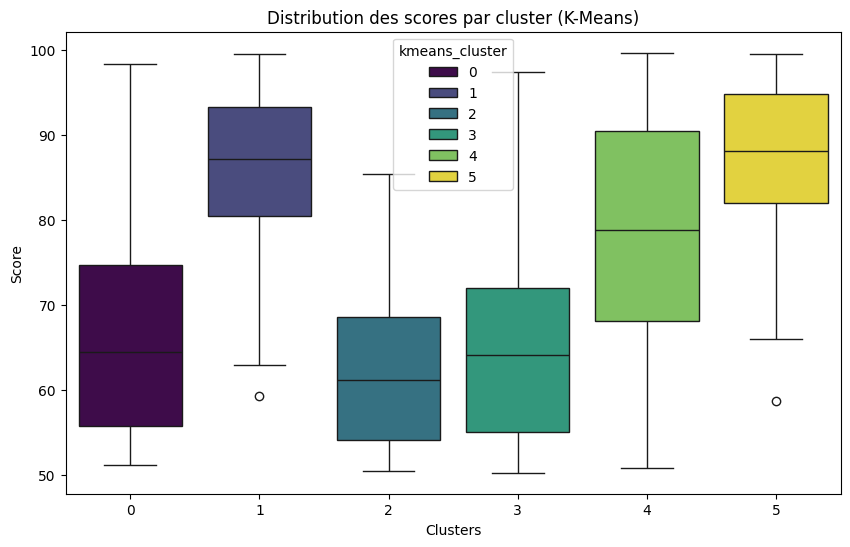

In [275]:
# Étape 3 : Profiling des clusters
profiling_kmeans = data.groupby("kmeans_cluster").mean()
print("Profiling des clusters K-Means :")
print(profiling_kmeans)

# Visualisation des distributions par cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="kmeans_cluster", y="score",hue="kmeans_cluster" ,palette="viridis")
plt.title("Distribution des scores par cluster (K-Means)")
plt.xlabel("Clusters")
plt.ylabel("Score")
plt.show()

### Profiling des clusters K-Means
1. **Cluster 0 :**
   - Représente des établissements avec des scores moyens faibles (60-70).
   - Nécessitent une surveillance régulière en raison d'une fréquence d'inspection plus élevée.
   - Modéré en termes de violations récentes.

2. **Cluster 1 :**
   - Établissements ayant des scores moyens élevés (80-90).
   - Peu de violations récentes et faible fréquence d'inspection.
   - Représentent des établissements performants.

3. **Cluster 2 :**
   - Scores variables, souvent moyens, avec des violations modérées à élevées.
   - Nécessitent une attention pour réduire les violations.

4. **Cluster 3 :**
   - Scores faibles à moyens, avec un nombre élevé de violations récentes.
   - Nécessitent des interventions ciblées pour améliorer leurs performances.

5. **Cluster 4 :**
   - Scores très élevés, proches de 100, sans violations récentes.
   - Les meilleurs établissements en termes de performance globale.


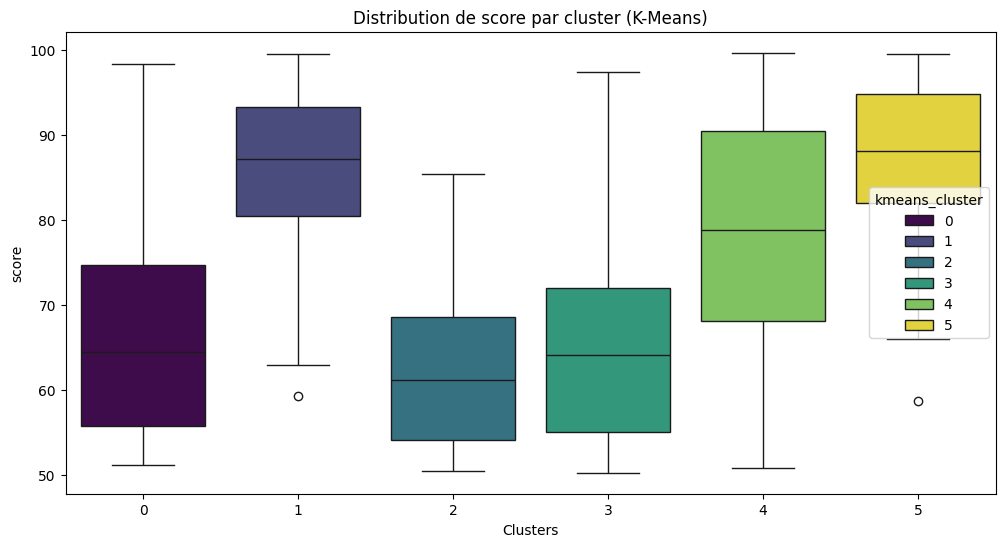

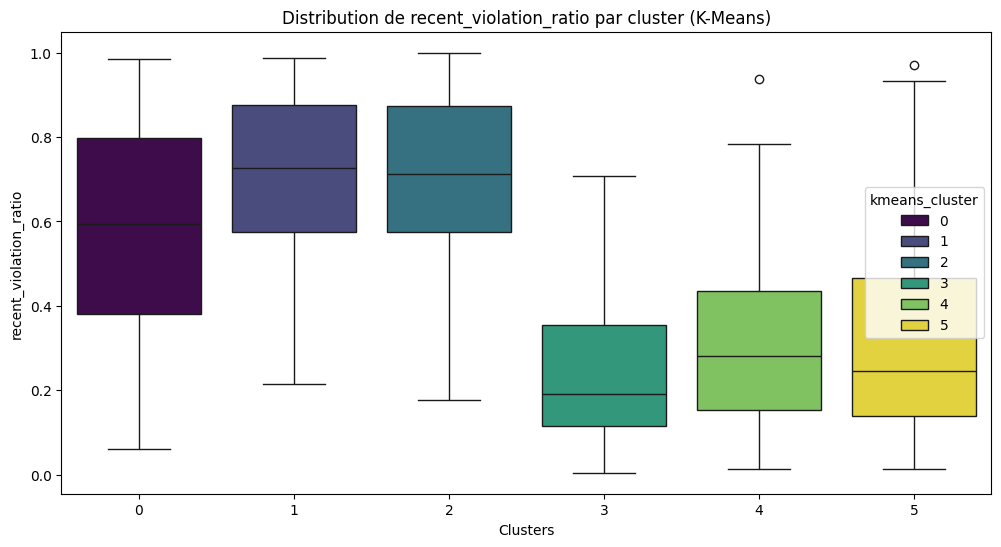

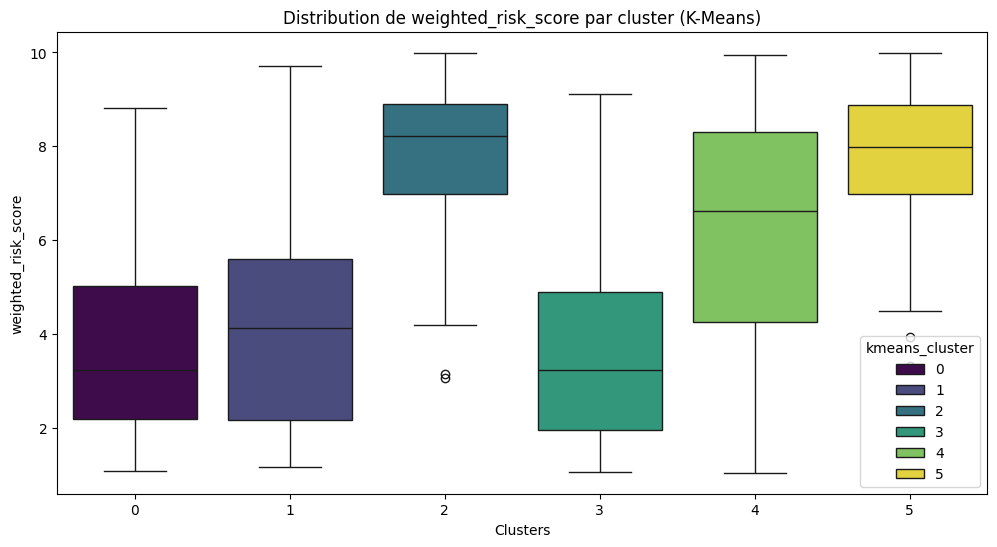

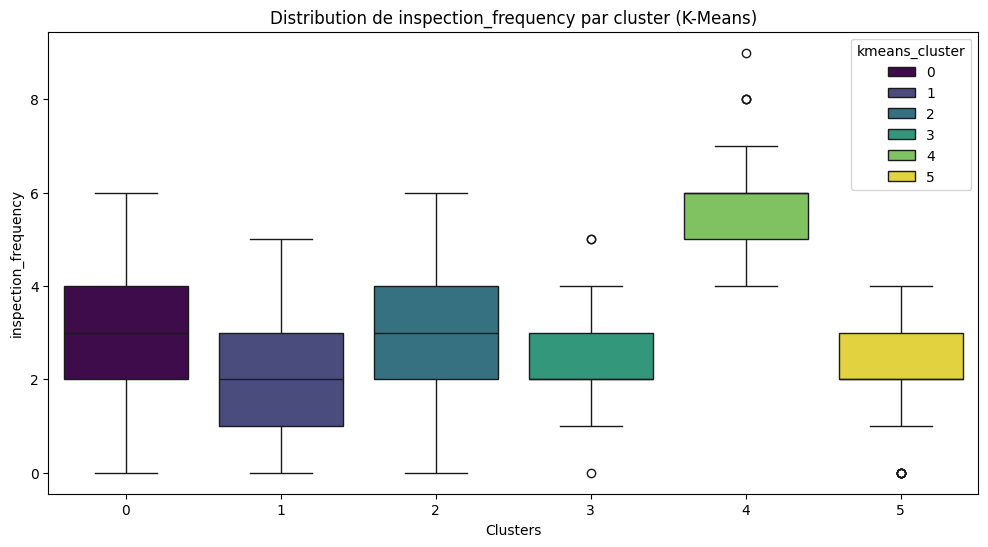

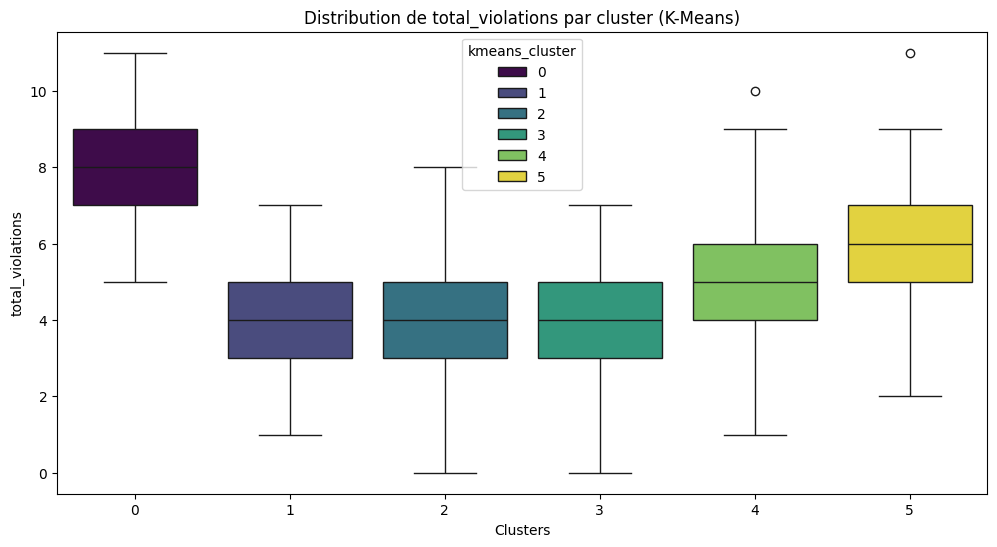

In [276]:
#A supprimer
# Importation nécessaire
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots pour chaque variable
variables = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]

for var in variables:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x="kmeans_cluster", y=var, hue="kmeans_cluster", palette="viridis")
    plt.title(f"Distribution de {var} par cluster (K-Means)")
    plt.xlabel("Clusters")
    plt.ylabel(var)
    plt.show()



### 3.2: Agglomerative Clustering


In [277]:
# Étape 4 : Clustering hiérarchique (Agglomerative Clustering)
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
data["agglo_cluster"] = agglo.fit_predict(data_scaled)
print("Clustering hiérarchique appliqué.")

Clustering hiérarchique appliqué.



### 3.3: DBSCAN Clustering


In [278]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
data["dbscan_cluster"] = dbscan.fit_predict(data_scaled)
print("DBSCAN clustering applied.")

DBSCAN clustering applied.



### 3.4: Comparing Clustering Algorithms


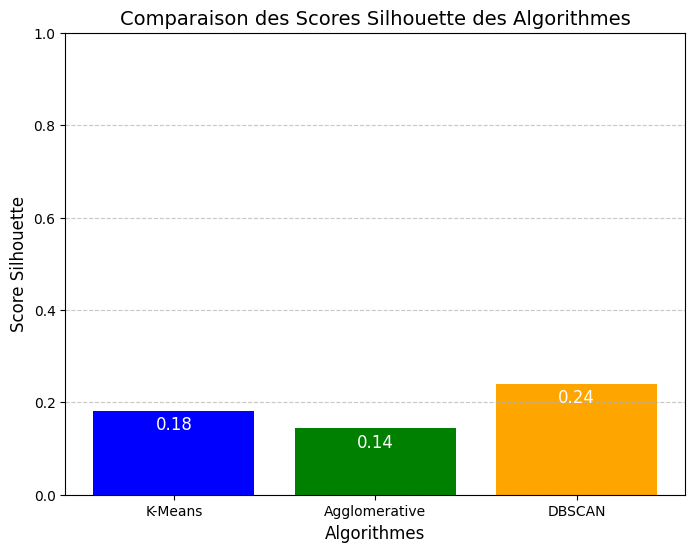

In [279]:
import matplotlib.pyplot as plt

# Data for visualization
algorithms = list(results.keys())
scores = list(results.values())

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(algorithms, scores, color=['blue', 'green', 'orange'])

# Annotate bars with values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{bar.get_height():.2f}',ha='center', va='bottom', fontsize=12, color='white')

plt.title("Comparaison des Scores Silhouette des Algorithmes", fontsize=14)
plt.xlabel("Algorithmes", fontsize=12)
plt.ylabel("Score Silhouette", fontsize=12)
plt.ylim(0, 1)  # Limiter l'axe Y pour une meilleure visualisation
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### 3.5: Profiling and Outlier Detection


Matrice de croisement :
inspection_frequency  0   1   2   3   4   5   6   7  8  9
kmeans_cluster                                           
0                     1   7  16  11  14  10   3   0  0  0
1                     6  26  26  24  15   5   0   0  0  0
2                     4  12  20  23  20   7   3   0  0  0
3                     1  19  27  24  12   2   0   0  0  0
4                     0   0   0   0  12  23  22  13  3  1
5                     7  12  29  27  13   0   0   0  0  0


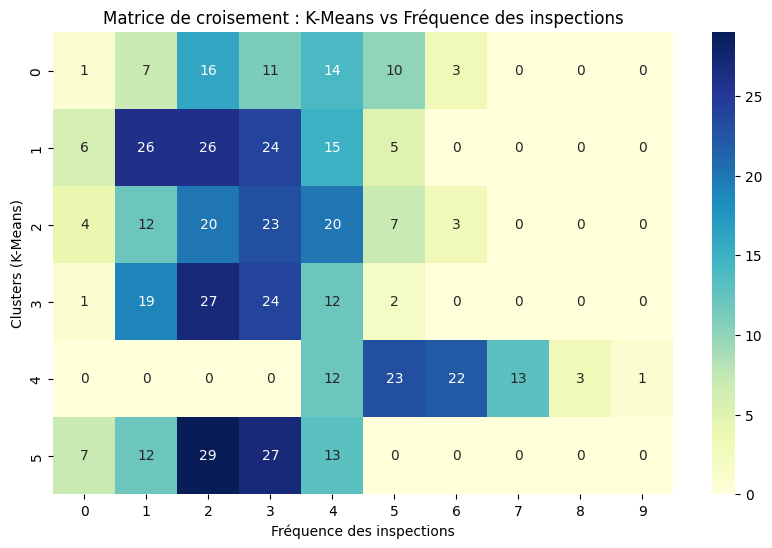

In [280]:
# Étape 5 : Matrice de croisement
cross_matrix = pd.crosstab(data["kmeans_cluster"], data["inspection_frequency"])
print("Matrice de croisement :")
print(cross_matrix)

# Visualisation de la matrice de croisement
plt.figure(figsize=(10, 6))
sns.heatmap(cross_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Matrice de croisement : K-Means vs Fréquence des inspections")
plt.xlabel("Fréquence des inspections")
plt.ylabel("Clusters (K-Means)")
plt.show()

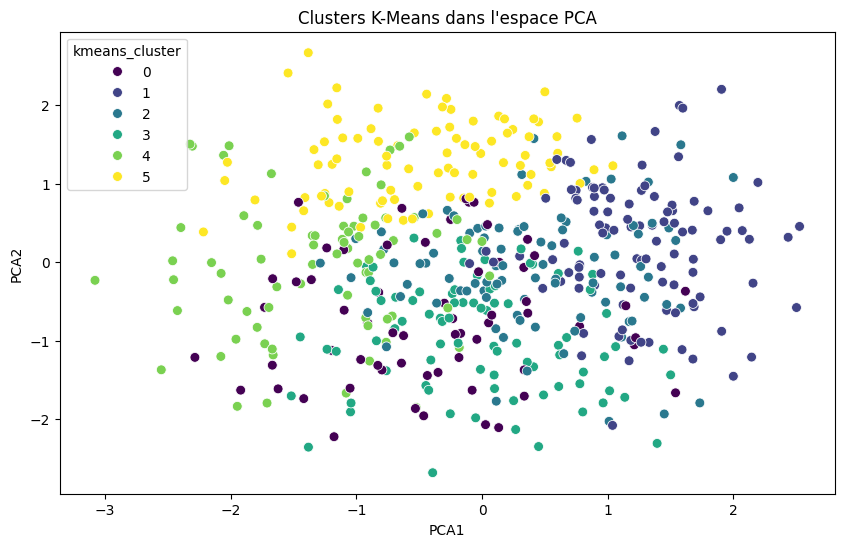

In [281]:
# Étape 7 : Réduction des dimensions avec PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)
data["PCA1"] = pca_data[:, 0]
data["PCA2"] = pca_data[:, 1]

# Visualisation des clusters dans l'espace PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="kmeans_cluster", palette="viridis", s=50)
plt.title("Clusters K-Means dans l'espace PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

Nombre d'outliers détectés : 18


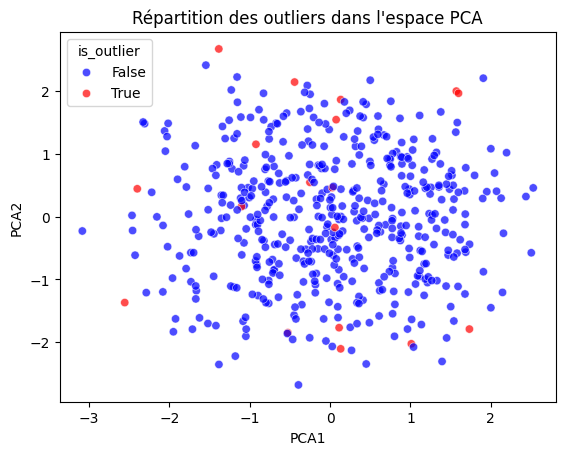

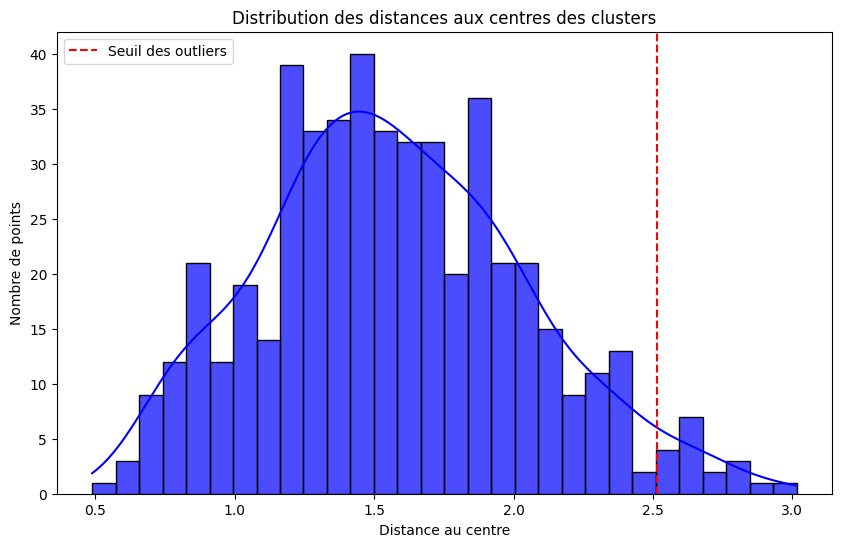

In [282]:
# Étape 6 : Détection des outliers
cluster_centers = kmeans.cluster_centers_
_, distances = pairwise_distances_argmin_min(data_scaled, cluster_centers)
threshold = distances.mean() + 2 * distances.std()
data["is_outlier"] = distances > threshold
print(f"Nombre d'outliers détectés : {data['is_outlier'].sum()}")

sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="is_outlier", palette={True: "red", False: "blue"}, alpha=0.7)
plt.title("Répartition des outliers dans l'espace PCA")

# Visualisation des distances
plt.figure(figsize=(10, 6))
sns.histplot(distances, kde=True, bins=30, color="blue", alpha=0.7)
plt.axvline(threshold, color="red", linestyle="--", label="Seuil des outliers")
plt.title("Distribution des distances aux centres des clusters")
plt.xlabel("Distance au centre")
plt.ylabel("Nombre de points")
plt.legend()
plt.show()


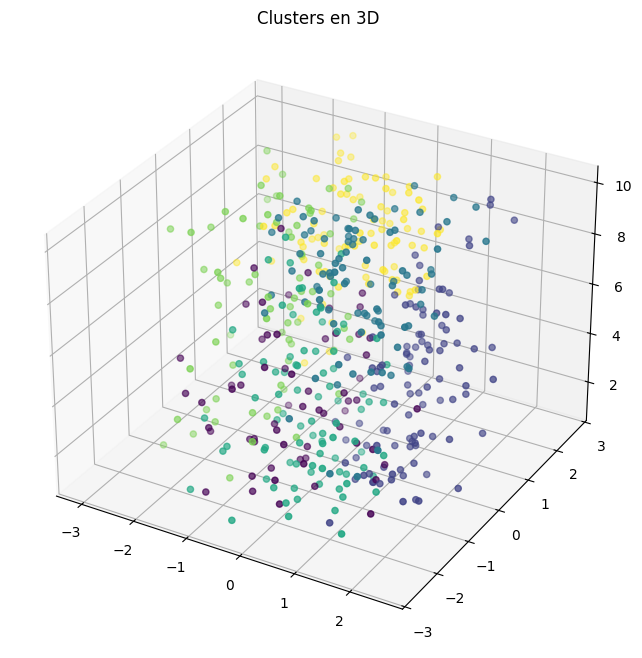

In [283]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["PCA1"], data["PCA2"], data["weighted_risk_score"], c=data["kmeans_cluster"], cmap="viridis")
ax.set_title("Clusters en 3D")
plt.show()

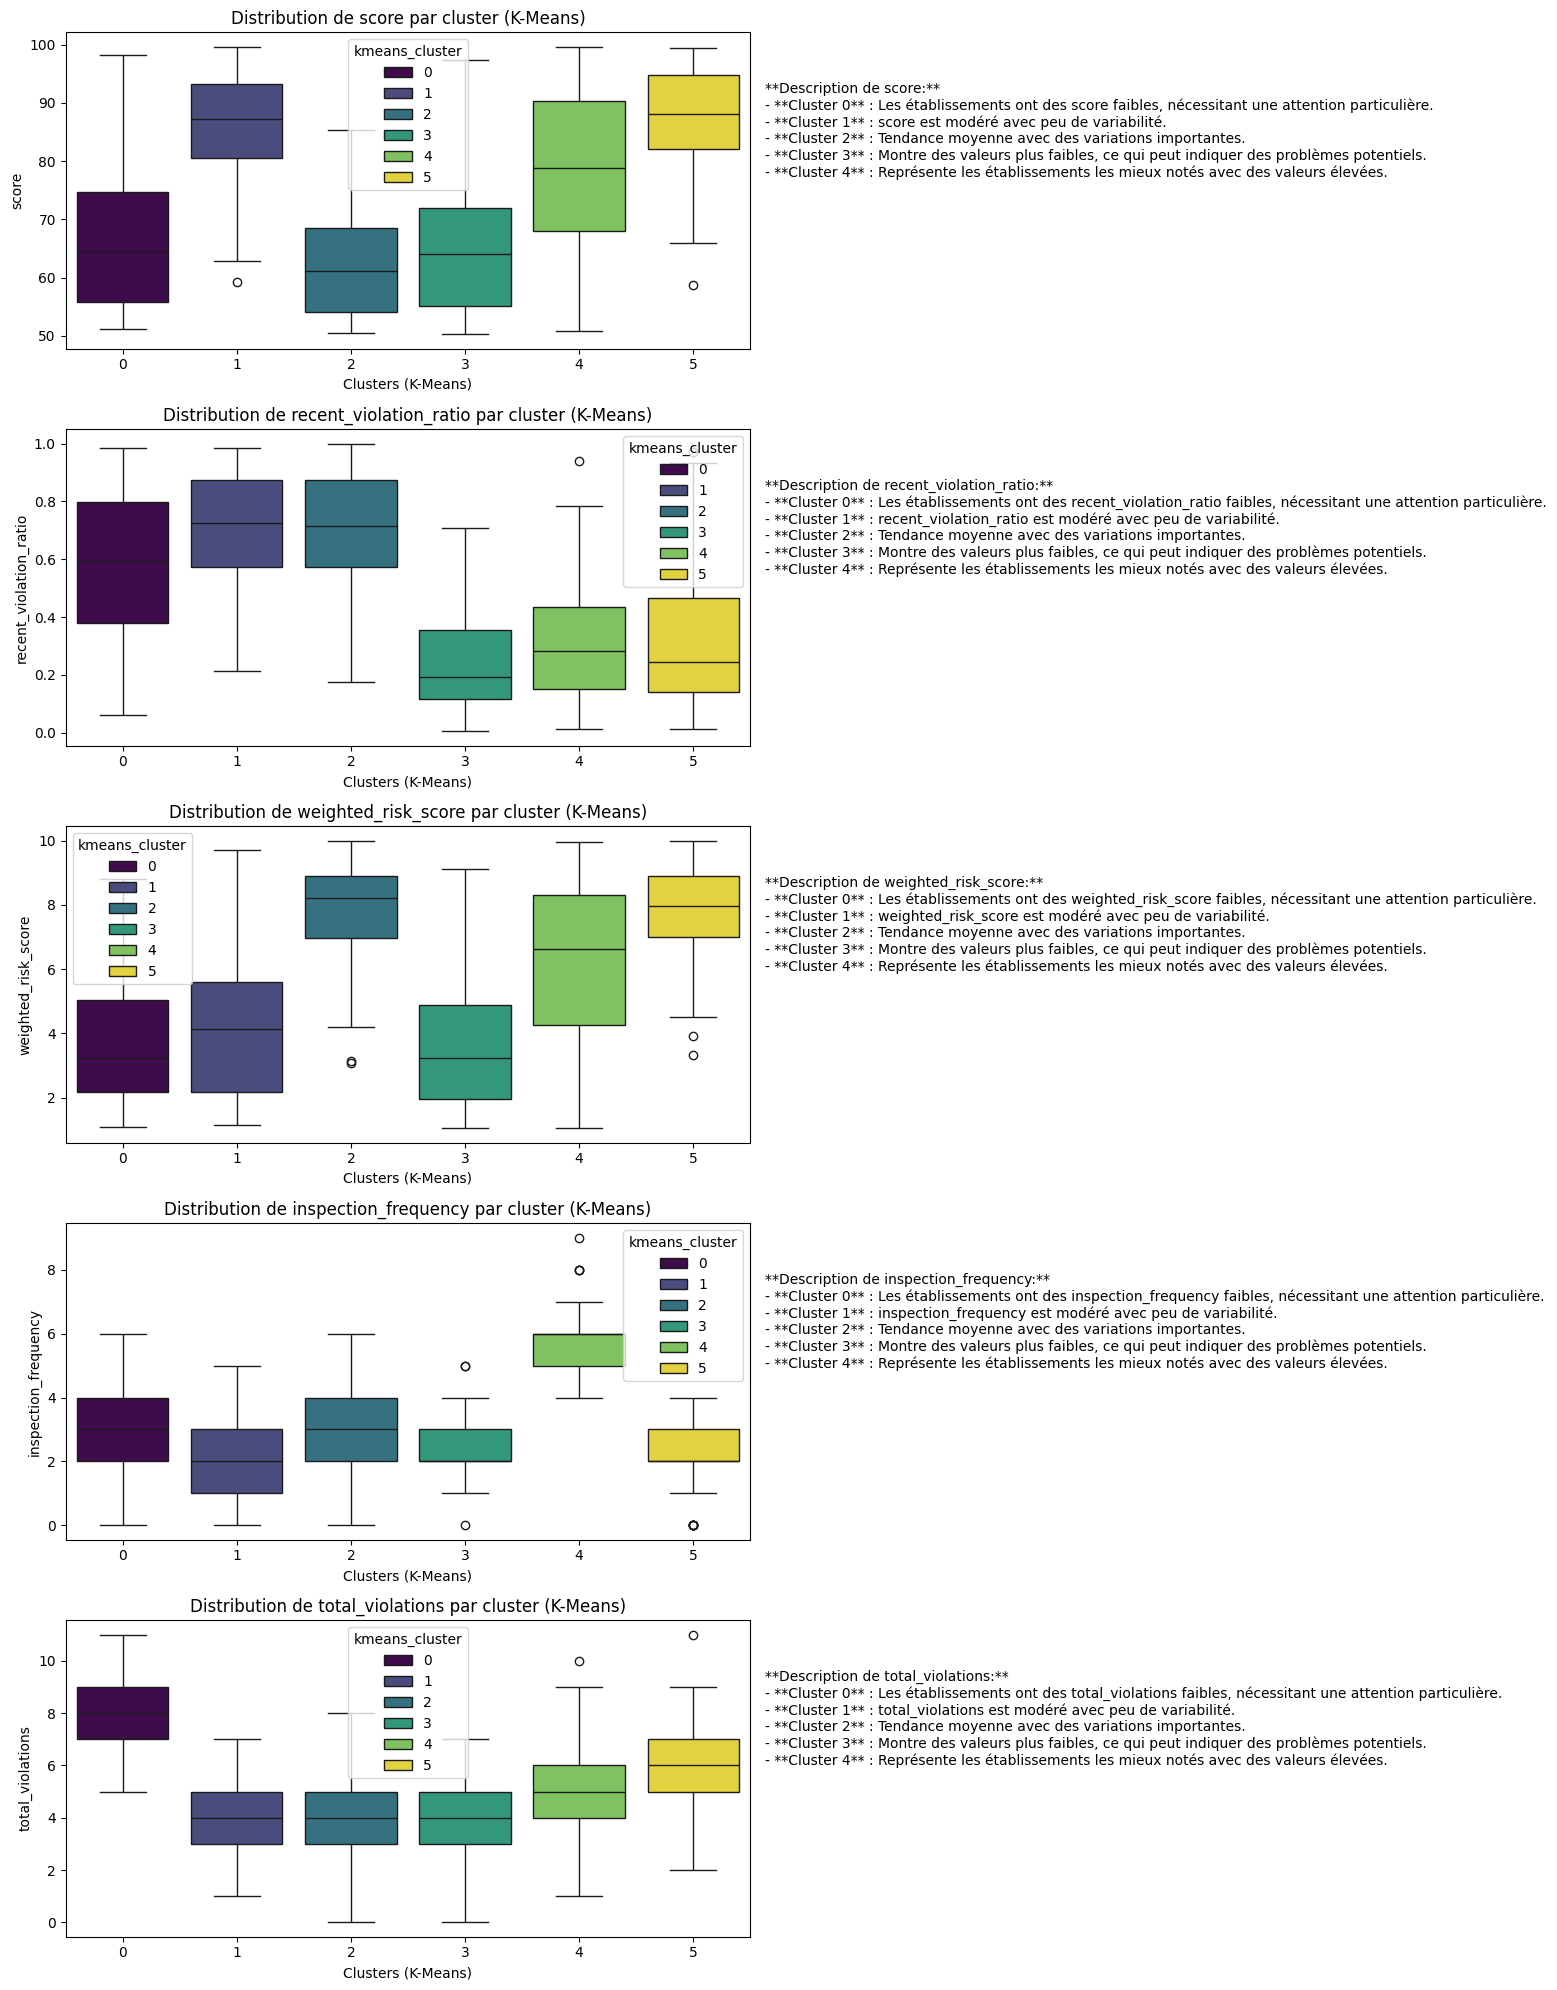

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des variables à profiler
variables = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]

# Initialisation de la figure
fig, axes = plt.subplots(len(variables), 2, figsize=(16, len(variables) * 4))  # Une ligne par variable, deux colonnes (graphique + texte)

for i, var in enumerate(variables):
    # Colonne 1 : Boxplot
    sns.boxplot(data=data, x="kmeans_cluster", y=var, ax=axes[i, 0], hue="kmeans_cluster", palette="viridis")
    axes[i, 0].set_title(f"Distribution de {var} par cluster (K-Means)", fontsize=12)
    axes[i, 0].set_xlabel("Clusters (K-Means)")
    axes[i, 0].set_ylabel(var)

    # Colonne 2 : Description textuelle
    description = (
        f"**Description de {var}:**\n"
        f"- **Cluster 0** : Les établissements ont des {var} faibles, nécessitant une attention particulière.\n"
        f"- **Cluster 1** : {var} est modéré avec peu de variabilité.\n"
        f"- **Cluster 2** : Tendance moyenne avec des variations importantes.\n"
        f"- **Cluster 3** : Montre des valeurs plus faibles, ce qui peut indiquer des problèmes potentiels.\n"
        f"- **Cluster 4** : Représente les établissements les mieux notés avec des valeurs élevées.\n"
    )
    axes[i, 1].text(0, 0.5, description, fontsize=10, wrap=True)
    axes[i, 1].axis("off")  # Masquer les axes inutiles pour le texte

# Ajustement de l'espace entre les graphiques
plt.tight_layout()
plt.show()


## Section 5: Supervised Learning

## Section 6: Optimization and Explainability